# Emergent Patterns in Ecosystems

$$Alberto \; Chimenti - 1210360;  \;\;\;  Anna \; Braghetto - 1205200;  \;\;\;  Davide \; Maniscalco - 1212063$$

In [23]:
import numpy as np
import math as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display
#from tqdm import tqdm        #Library for update bar

%matplotlib inline

# Task 1

The dataset repots 299 different spieces


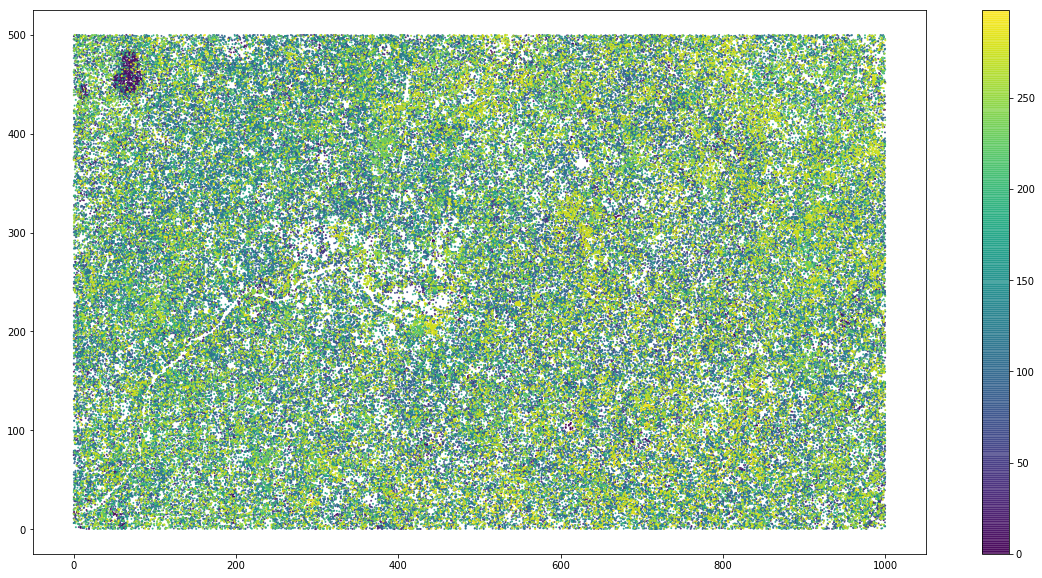

In [3]:
#Load the data
data = pd.read_csv("bci05.csv")
data = data[data['status']=='A']  #Selecting alive species
data.drop(['status','tag','dbh', 'date', 'codes','pom'],axis=1, inplace=True)
nspieces=len(data.groupby(data['sp']).size()) #Number of species
print('The dataset repots %d different spieces'%nspieces)

#Visualization
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
col_grade=label_encoder.fit_transform(data['sp']) #Color grading for each specie
fig=plt.figure(figsize=(20,10))
plot=plt.scatter(data['gx'], data['gy'], c=col_grade, alpha=0.8, s=1)
plt.colorbar(plot)
fig.savefig('images\Forest_plot.png')
plt.show()

In [4]:
#Data separation
groups=np.zeros(len(data))
l=0
for i in np.arange(40):
    mask1 = np.logical_and(data['gx']>=((25)*(i)), data['gx']<=((25)*(i+1)))
    for j in np.arange(20):
        mask2 = np.logical_and(data['gy']>=(25*j), data['gy']<=(25*(j+1)))
        mask = np.logical_and(mask1,mask2)
        groups[mask]= l
        l+=1
data['groups']=groups

In [5]:
#Abundancies of each specie
temp=data.groupby(['groups','sp']).size() #Pandas Series with the different species population divided in subplots
ab=pd.DataFrame(columns=data['sp'].unique()) #Dataframe init
for i in np.arange(800):
    ab=ab.append([temp[i]]) #Appending subplot population matching column indexes
ab.fillna(0, inplace=True)
ab.index=np.arange(800)

#Presence vector
x=np.ravel(ab.values)
x=x[x!=0]

# Task 2

In [6]:
#Empirical Cumulative Distribution Function
def ECDF(x,p):
    return len(x[x>=p])/len(x)

def ecdf_vals(values, ECDF=ECDF):
    ecdf=np.zeros(len(values))
    for i,p in enumerate(values):
        ecdf[i]=ECDF(x,p)
    return ecdf

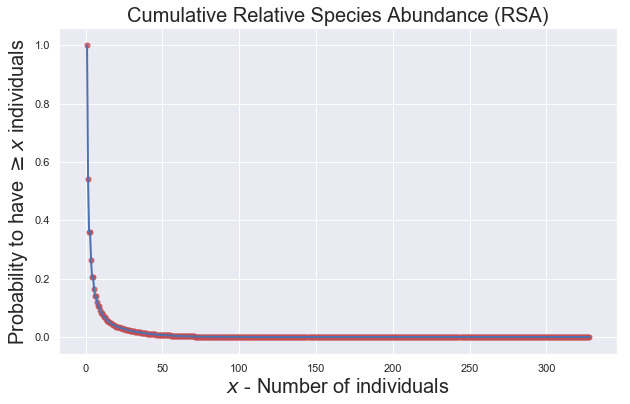

In [7]:
sns.set()
#Example plot
x_max=np.max(x)
length=500
points=np.linspace(1,x_max,length)
ecdf=ecdf_vals(points)  
fig=plt.figure(figsize=(10,6)); ax=plt.axes()
ax.plot(points,ecdf, linewidth=2, color='C0')
ax.scatter(points, ecdf, color='C3', s=25, alpha=0.8, marker='o')
ax.set_xlabel('$x$ - Number of individuals', fontsize=20)
ax.set_ylabel('Probability to have $\geq x$ individuals', fontsize=20)
ax.set_title('Cumulative Relative Species Abundance (RSA)', fontsize=20)
plt.savefig('images\CRSA.png')
plt.show()

# Task 3

$$b_n=bn,\,\, d_n = dn, \,\, b_0=m$$

$$P_n=P_0\frac{(n-1)!b^{n-1}m}{n!d^n}$$

$$P_n=P_0 \frac{mr^n}{bn} \; \; \; \; \; \text{with } r=\frac{b}{d}$$

Normalization:
$$\sum_{n=1}^{\infty} P_n= 1 = P_0 \frac{m}{b} \sum_{n=1}^{\infty} \int_0^r x^{n-1}dx=P_0 \frac{m}{b} \int_0^r \frac{1}{1-x}dx \; \; \; \; \; \rightarrow \; \; \; 1=-P_0\frac{m}{b} \log(1-r) $$

$$\Rightarrow P_0=-\frac{b}{m}\frac{1}{\log(1-\frac{b}{d})}$$

$$\Rightarrow P_n= -\frac{1}{n\log(1-\frac{b}{d})}\left(\frac{b}{d}\right)^n$$

If we put $b=1-m$ and $d=1$ we find the equation computed in class:

$$P_n= -\frac{\left(1-m\right)^n}{n\log(m)}$$

In [8]:
def PDF(x, d=1, m=0.05):
    return -((1-m)/d)**x/(np.log(1-((1-m)/d))*x)

def cont_CDF(values, m, d=1):
    CDF=np.zeros(len(values))
    for i, val in enumerate(values):
        CDF[i], err =integrate.quad(PDF,1,val, args=(d, m))
    norm, err=integrate.quad(PDF,1,np.inf, args=(d, m))
    return 1-CDF/norm 

def discrete_CDF(values, m, d=1):
    CDF=np.zeros(len(values))
    for i in np.arange(len(values)):
        CDF[i]=sum(PDF(values[i:], d, m))
    return CDF

In [9]:
#Computing CDF in continuous and discrete case
top=x_max
d=1
continuous= np.linspace(1, top, top*10)
discrete= np.arange(1,top, dtype=int)

CDF_cont=cont_CDF(continuous, m=0.05)
CDF_disc=discrete_CDF(discrete, m=0.05)

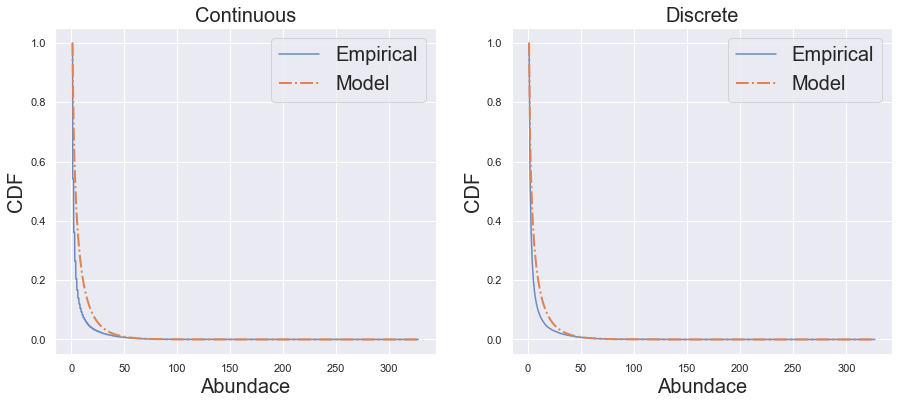

In [10]:
#Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

xx=np.linspace(1,x_max, 500)
ax[0].plot(continuous,ecdf_vals(continuous), label='Empirical', alpha=0.8)
ax[0].plot(continuous,CDF_cont, label='Model', linestyle='-.', linewidth=2)
ax[0].set_ylabel('CDF', fontsize=20)
ax[0].set_xlabel('Abundace', fontsize=20)
ax[0].set_title('Continuous', fontsize=20)
ax[0].legend(fontsize=20);
ax[1].plot(discrete,ecdf_vals(discrete), label='Empirical', alpha=0.8)
ax[1].plot(discrete,CDF_disc, label='Model', linestyle='-.', linewidth=2)
ax[1].set_ylabel('CDF', fontsize=20)
ax[1].set_xlabel('Abundace', fontsize=20)
ax[1].set_title('Discrete', fontsize=20)
ax[1].legend(fontsize=20);
plt.savefig('images\B_D_ME.png')

In [11]:
#Fit
popt_d, pcov_d = curve_fit(discrete_CDF, discrete, ecdf_vals(discrete), 0.05)
popt_c, pcov_c = curve_fit(cont_CDF, continuous, ecdf_vals(continuous), 0.05)
print(popt_d, pcov_d)
print('-------------')
print(popt_c, pcov_c)

[0.11734584] [[3.35242032e-06]]
-------------
[0.18382754] [[3.72542752e-06]]


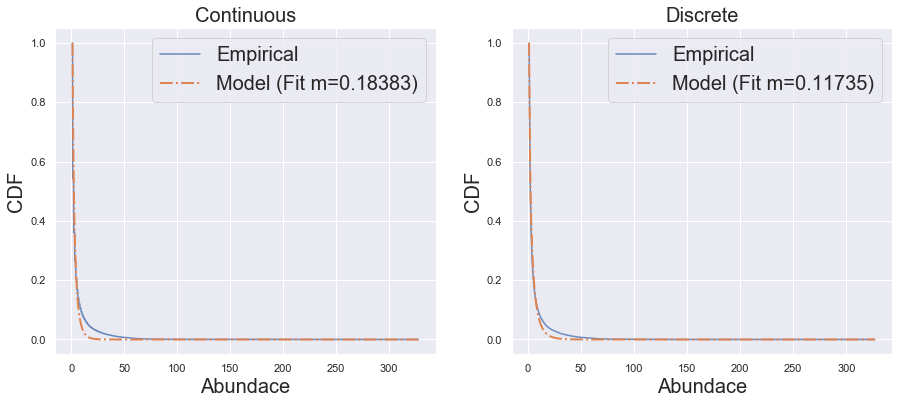

In [12]:
#Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax[0].plot(continuous,ecdf_vals(continuous), label='Empirical', alpha=0.8)
ax[0].plot(continuous,cont_CDF(continuous, m=popt_c[0]), label=('Model (Fit m=%.5f)'%popt_c[0]), linestyle='-.', linewidth=2)
ax[0].set_ylabel('CDF', fontsize=20)
ax[0].set_xlabel('Abundace', fontsize=20)
ax[0].set_title('Continuous', fontsize=20)
ax[0].legend(fontsize=20);
ax[1].plot(discrete,ecdf_vals(discrete), label='Empirical', alpha=0.8)
ax[1].plot(discrete,discrete_CDF(discrete, m=popt_d[0]), label=('Model (Fit m=%.5f)'%popt_d[0]), linestyle='-.', linewidth=2)
ax[1].set_ylabel('CDF', fontsize=20)
ax[1].set_xlabel('Abundace', fontsize=20)
ax[1].set_title('Discrete', fontsize=20)
ax[1].legend(fontsize=20);
plt.savefig('images\B_D_ME_fit.png')

# Task 4

In [13]:
presence = ab.copy()
presence[presence>0]=1

In [15]:
%time
#total area
A=500000
#area of each subplot
a=625
#number of species
Species=299

averages=np.zeros(800)    #vectors of values and errors initialized to 0
std=np.zeros(800)

aj=np.zeros(800)

for i in range(0,800):
    aj[i]=a*(i+1)           #areas from 625 m^2 to 500000

temppres=presence.copy()

repeat=100                  #number of elements of the average
t=np.zeros((800,repeat))

for j in range(repeat):
    #to compute std
    temppres=presence.copy()
    temppres=temppres.sample(frac=1).reset_index(drop=True)  #random sample of the presence vector
    averages[0] += temppres.sum(axis=1)[0]                   # avereage
    t[0,j] = temppres.sum(axis=1)[0]
    for i in range(1,800):
        temppres.loc[i] = temppres.loc[i]+temppres.loc[i-1]  #sum of the species over the subplots
        temppres.loc[i][temppres.loc[i]>0]=1
        averages[i] += temppres.sum(axis=1)[i]
        t[i,j] = temppres.sum(axis=1)[i]

std=np.std(t,axis=1)  
averages /= repeat

Wall time: 0 ns


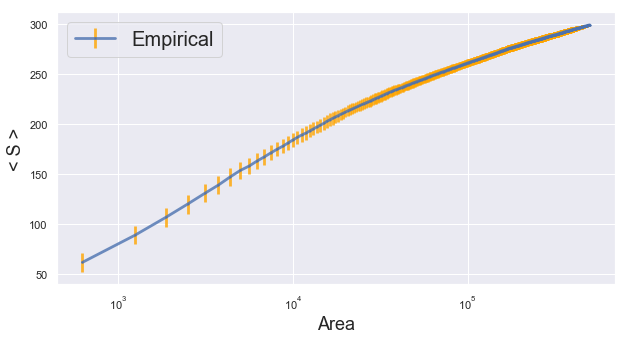

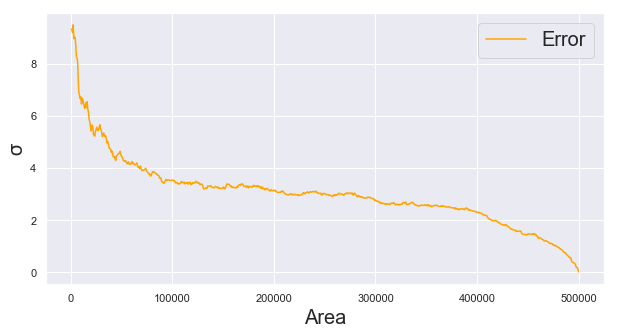

In [16]:
#Visualization
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(aj,averages,std,marker='o',markersize=1, ecolor='orange', label='Empirical', alpha=0.8, linewidth=2.8);
ax.set_xlabel('Area', fontsize=18)
ax.set_ylabel('< S >', fontsize=18)
ax.legend(fontsize=20)
ax.set_xscale('log')   #logarithmic scale
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(aj,std,label='Error',c='orange')
ax.set_xlabel('Area', fontsize=20)
ax.set_ylabel('σ', fontsize=20)
ax.legend(fontsize=20)
plt.savefig('images\errori2.png')
plt.show()

### Fit

In [17]:
#Theoretical SAR formula
def Smean(x,m):
    y=x/A
    num = np.log(y*(1-m)+m)
    den = np.log(m)
    return Species*(1-num/den)

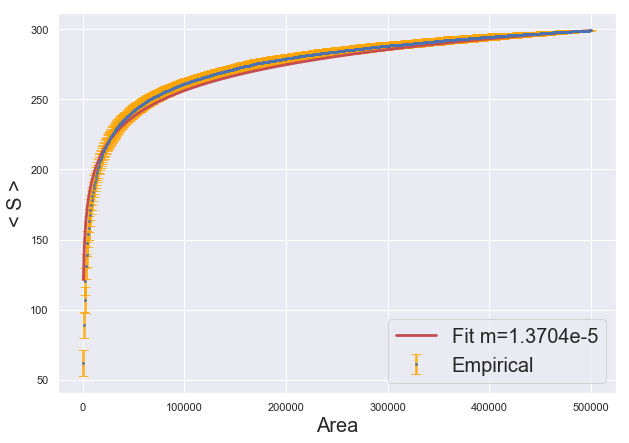

In [18]:
#Fit
popt, pcov = curve_fit(Smean, aj, averages, 1e-10)

#Visualize
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(aj,averages,std, fmt='o', markersize= 2,ecolor='orange', label='Empirical', alpha=0.8, linewidth=2.8
           , capsize=5)
ax.plot(aj,Smean(aj,popt[0]), c='r',label='Fit m=1.3704e-5', alpha=1,linewidth=2.8)
ax.set_xlabel('Area', fontsize=20)
ax.set_ylabel('< S >', fontsize=20)
#ax.set_xscale('log')
ax.legend(fontsize=20,loc=4);
plt.savefig('images\empirica_e_modello2.png')

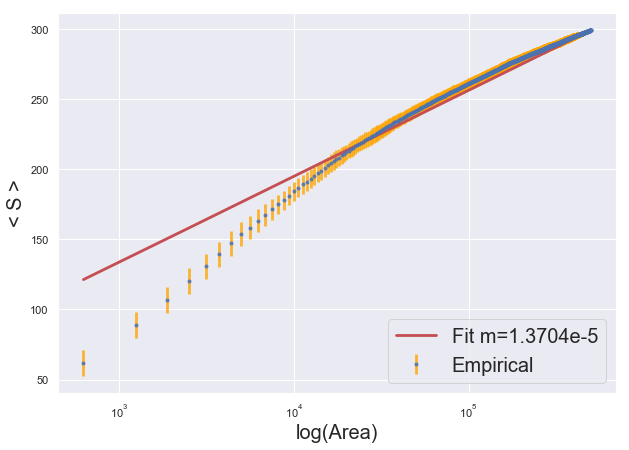

In [19]:
#Fit, logarithmic scale
popt, pcov = curve_fit(Smean, aj, averages, 1e-10)

#Visualize
fig, ax = plt.subplots(figsize=(10,7))
ax.errorbar(aj,averages,std, fmt='o', markersize= 3,ecolor='orange', label='Empirical', alpha=0.8, linewidth=2.8)
ax.plot(aj,Smean(aj,popt[0]), c='r',label='Fit m=1.3704e-5', alpha=1,linewidth=2.8)
ax.set_xlabel('log(Area)', fontsize=20)
ax.set_ylabel('< S >', fontsize=20)
ax.set_xscale('log')
ax.legend(fontsize=20,loc=4);
plt.savefig('images\log.png')

# Task 5

The transition rates $W^+(A)$ and $W^-(A)$ are defined as follows:

$$W^+(A)=m+bA$$
$$W^-(A)=Ad(A)=\frac{A^2}{K}b$$

The Birth and Death Master Equation is:

$$\frac{d P_A(t)}{dt}=W^+(A-1)P_{A-1}(t)+W^-(A+1)P_{A+1}(t)+\Big(W^+(A)+W^-(A)\Big)P_{A}(t)$$

The stationary state is:

$$P_A = \frac{W^+(A-1)}{W^-(A)}\frac{W^+(A-2)}{W^-(A-1)}\cdot \cdot \frac{W^+(0)}{W^-(1)}$$

by replacing the rates found above, it becomes:

$$P_A = \frac{m+(A-1)b}{\frac{A^2}{K}b} \cdot \frac{m+(A-2)b}{\frac{(A-1)^2}{K}b} \cdot \cdot \cdot \frac{m}{\frac{b}{K}}$$

$$P_A=P_0\cdot \left(\frac{K}{b}\right)^A \frac{1}{A!^2} \prod_{i=1}^{A}\left[ m+(A-i)b \right]$$

To find the normalization constant $P_0$ we put:

$$1=\sum_{A=1}^\infty P_A $$

In [20]:
#parameters of the stationary state
k=10
b=1
m=0.1

In [24]:
#definition of the stationary state
def PA(A):
    prod=1
    for i in range(1,A+1):
        prod *= (m+(A-i)*b)
    return prod/((b/k)**A*ma.factorial(A)**2)

#normalization constant
def P0():
    p0=0
    for j in range(1,41):
        p0 += PA(j) 
    return p0

#computing PA
pt = np.zeros(20)
for i in range(1,21):
    pt[i-1] = PA(i)/P0()
    
print('The normalization constant P0 is',P0())

The normalization constant P0 is 321.2524257219482


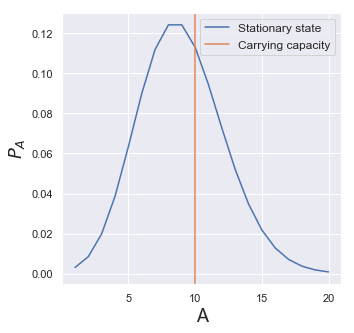

In [35]:
#Visualization
fig, ax = plt.subplots(figsize=(5,5))

xx=np.linspace(1,20,20)
ax.set_xlabel('A', fontsize=18)
ax.set_ylabel('$P_A$', fontsize=18)
ax.plot(xx,pt, label='Stationary state')
ax.axvline(10,c='C1', label='Carrying capacity')
ax.legend(fontsize=12);
plt.savefig('images\Task5.png')